# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Load-libraries" data-toc-modified-id="Load-libraries-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Load libraries</a></div><div class="lev1 toc-item"><a href="#Load-previously-trained-model" data-toc-modified-id="Load-previously-trained-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load previously trained model</a></div><div class="lev1 toc-item"><a href="#Generate-predictions" data-toc-modified-id="Generate-predictions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Generate predictions</a></div>

# Load libraries

In [1]:
import cv2
import numpy as np
import pandas as pd

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization
from keras.optimizers import RMSprop
from keras.losses import binary_crossentropy
import keras.backend as K

from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from os import listdir
ids_list = [x.split('.')[0] for x in listdir('data/train')]

# Load previously trained model

In [4]:
def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + (1 - dice_loss(y_true, y_pred))

def unet_down_one_block(inputs, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def unet_max_pool(inputs):
    x = MaxPooling2D((2, 2), strides=(2, 2))(inputs)
    return x

def unet_up_one_block(up_input, down_input, num_filters):
    x = UpSampling2D((2,2))(up_input)
    x = concatenate([down_input, x], axis=3)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(num_filters, (3,3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def get_unet(input_shape = (256, 256, 3),
             num_classes = 1,
             initial_filters = 32,
             central_filters = 1024):
    
    num_filters = initial_filters
    
    out_list    = [Input(shape=input_shape)]
    down_interim_list = []
    
    while num_filters <= central_filters/2:
        x = unet_down_one_block(out_list[-1], num_filters)
        down_interim_list.append(x)
        num_filters = num_filters * 2
        y = unet_max_pool(x)
        out_list.append(y)
    
    x = unet_down_one_block(out_list[-1], num_filters)
    out_list.append(x)
    num_filters = int(num_filters / 2)
    
    while num_filters >= initial_filters:
        x = unet_up_one_block(out_list[-1], down_interim_list.pop(), num_filters)
        out_list.append(x)
        num_filters = int(num_filters / 2)
    
    classify = Conv2D(num_classes, (1,1), activation = 'sigmoid')(out_list[-1])
    
    model = Model(inputs=out_list[0], outputs=classify)
    
    model.compile(optimizer=RMSprop(lr=0.0001),
                  loss=bce_dice_loss,
                  metrics=[dice_loss])
    
    return model

model = get_unet(input_shape=(128,128,3), initial_filters=64)
model.load_weights(filepath='weights/best_weights_128.hdf5')

# Generate predictions

In [5]:
import pickle

In [6]:
with open("data/all_imgs_resized_128.pkl", "rb") as f:
    all_imgs = pickle.load(f)

In [7]:
preds = model.predict(np.array(all_imgs, np.float32)/255, batch_size=64)
preds = np.squeeze(preds, axis=3)

In [10]:
preds = (preds > 0.5).astype(int)

In [75]:
def find_bounding_boxes(i):
    tmp = np.copy(preds[i,:,:])
    
    axis_0_sum = np.sum(tmp, axis=0)
    axis_1_sum = np.sum(tmp, axis=1)
    
    y_min = np.nonzero(axis_1_sum)[0][0]
    y_max = np.nonzero(axis_1_sum)[0][-1]
    
    x_min = np.nonzero(axis_0_sum)[0][0]
    x_max = np.nonzero(axis_0_sum)[0][-1]
    
    return (x_min, x_max, y_min, y_max)

In [80]:
def plot_bounding_box(i):
    (x_min, x_max, y_min, y_max) = find_bounding_boxes(i)
    tmp = np.copy(preds[i,:,:])
    tmp[y_min,:] = -1
    tmp[y_max,:] = -1
    tmp[:,x_min] = -1
    tmp[:,x_max] = -1
    plt.figure(figsize=(10, 10))
    plt.imshow(tmp);

(41, 91, 47, 104)


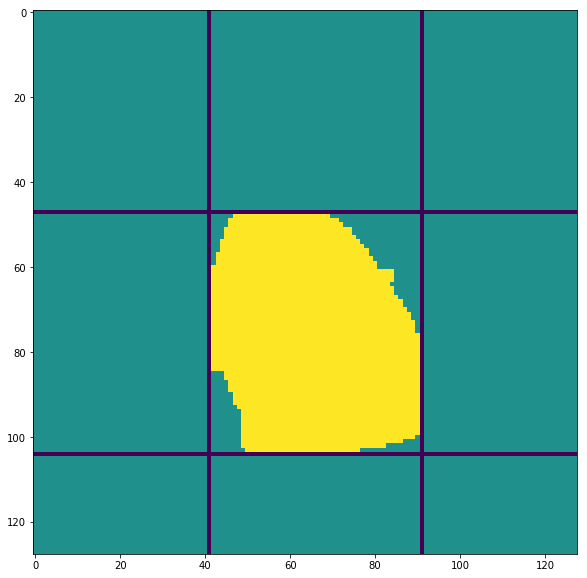

In [82]:
print(find_bounding_boxes(10))
plot_bounding_box(10)

In [83]:
all_bboxes = [find_bounding_boxes(i) for i in range(len(ids_list))]

In [85]:
import pickle
pickle.dump( all_bboxes, open( "bboxes.pkl", "wb" ) )